In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18

In [4]:
train_dir = "../dataset_output/lsa64_images/imgs_lopo/train/"
test_dir = "../dataset_output/lsa64_images/imgs_lopo/test/"
validate_dir = "../dataset_output/lsa64_images/imgs_lopo/validate/"

In [5]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Load dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
validate_dataset = datasets.ImageFolder(root=validate_dir, transform=transform)

In [6]:
# # Split dataset into train and test
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)

In [8]:
# Load pre-trained ResNet18 model
resnet = resnet18(pretrained=True)

/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
num_ftrs = resnet.fc.in_features

In [10]:
# Modify the fully connected layer to match the number of classes
resnet.fc = nn.Linear(num_ftrs, 64)

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.004)

In [12]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
from datetime import datetime

In [23]:
epochs = 10
history = {"loss": [], "accuracy": []}
for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    
    resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    history["loss"].append(float(loss))
    history["accuracy"].append(float(accuracy))

    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {accuracy:.4f}")
    print(str(datetime.now()))

Epoch 1/10, Loss: 0.0646, Val Accuracy: 0.7406
2024-03-10 15:08:17.529179
Epoch 2/10, Loss: 0.0938, Val Accuracy: 0.7266
2024-03-10 15:08:50.472503
Epoch 3/10, Loss: 0.1067, Val Accuracy: 0.7156
2024-03-10 15:09:20.864864
Epoch 4/10, Loss: 0.0773, Val Accuracy: 0.7766
2024-03-10 15:09:51.305722
Epoch 5/10, Loss: 0.0627, Val Accuracy: 0.7438
2024-03-10 15:10:20.523441
Epoch 6/10, Loss: 0.0416, Val Accuracy: 0.7219
2024-03-10 15:10:54.108256
Epoch 7/10, Loss: 0.0495, Val Accuracy: 0.7125
2024-03-10 15:11:25.006572
Epoch 8/10, Loss: 0.0430, Val Accuracy: 0.7703
2024-03-10 15:11:59.129436
Epoch 9/10, Loss: 0.0711, Val Accuracy: 0.7703
2024-03-10 15:12:29.679247
Epoch 10/10, Loss: 0.0414, Val Accuracy: 0.7453
2024-03-10 15:13:03.607069


In [24]:
resnet.eval()
correct = 0
total = 0
class_correct = list(0. for _ in range(64))
class_total = list(0. for _ in range(64))

In [25]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [26]:
accuracy = correct / total
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.8250


In [27]:
0.9375 - accuracy

0.11250000000000004

In [20]:
from matplotlib import pyplot as plt

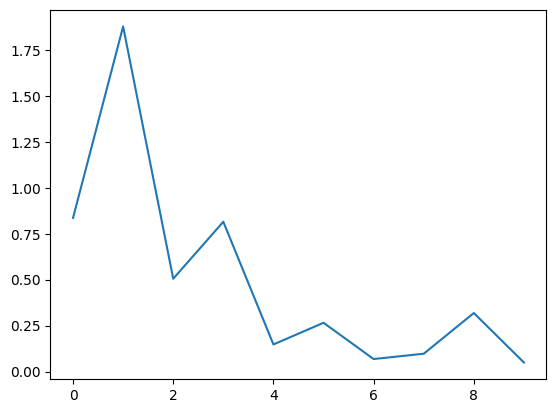

In [21]:
plt.plot(history["loss"])

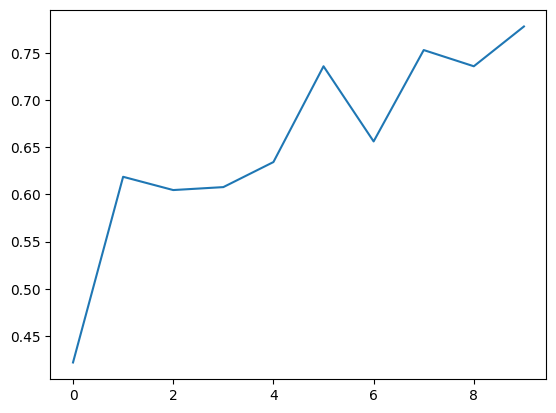

In [22]:
plt.plot(history["accuracy"])